# BM25 (Best Matching 25) Model Implementation

This notebook implements a BM25 model following the requirements:
1. Introduction to BM25 model
2. Term selection methodology
3. Term weight calculation formula
4. Index creation
5. Query processing
6. Evaluation on Cranfield dataset using P, R and MAP metrics


In [17]:
# Import necessary libraries
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, Counter
import ir_datasets
from itertools import islice
import math

# Additional imports for preprocessing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import warnings
warnings.filterwarnings('ignore')

# BM25 implementation library
try:
    from rank_bm25 import BM25Okapi
    print("Using rank_bm25 library")
except ImportError:
    print("rank_bm25 not available, will implement BM25 manually")
    BM25Okapi = None

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Load Cranfield dataset using ir_datasets
dataset = ir_datasets.load("cranfield")

print("Libraries imported successfully!")
print("Cranfield dataset loaded!")


Using rank_bm25 library
Libraries imported successfully!
Cranfield dataset loaded!


## 1. Giới thiệu mô hình BM25 (Best Matching 25)

**BM25 (Best Matching 25)** là một hàm xếp hạng được sử dụng rộng rãi trong lĩnh vực truy xuất thông tin (Information Retrieval):

### Phương pháp biễu diễn tài liệu và truy vấn:
- **Probabilistic Model**: Dựa trên mô hình xác suất để tính toán mức độ liên quan
- **Term Frequency**: Xem xét tần suất xuất hiện của từ trong tài liệu
- **Document Length Normalization**: Chuẩn hóa theo độ dài tài liệu để tránh bias
- **Inverse Document Frequency**: Tính trọng số dựa trên độ hiếm của từ

### Nguyên tắc tính toán độ liên quan để xếp hạng:
1. **BM25 Score**: Tính toán điểm số BM25 cho mỗi cặp query-document
2. **Parameter Tuning**: Sử dụng các tham số k1 (term frequency saturation) và b (length normalization)
3. **Ranking**: Xếp hạng tài liệu theo điểm số BM25 từ cao xuống thấp

### Ưu điểm của BM25:
- Hiệu quả cao trong thực tế
- Cân bằng tốt giữa term frequency và document length
- Được sử dụng làm baseline trong nhiều hệ thống tìm kiếm
- Dễ hiểu và triển khai


In [18]:
# Load Cranfield dataset using ir_datasets
documents = {}
queries = {}

# Load documents
for doc in dataset.docs_iter():
    documents[str(doc.doc_id)] = doc.text

# Load queries  
for query in dataset.queries_iter():
    queries[str(query.query_id)] = query.text

print(f"Loaded {len(documents)} documents")
print(f"Loaded {len(queries)} queries")
print("\nFirst few document IDs:", list(documents.keys())[:5])
print("\nFirst query:")
print(f"Query 1: {queries.get('1', 'Not found')}")
print("\nFirst document:")
print(f"Document 1: {documents.get('1', 'Not found')[:200]}...")


Loaded 1400 documents
Loaded 225 queries

First few document IDs: ['1', '2', '3', '4', '5']

First query:
Query 1: what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .

First document:
Document 1: experimental investigation of the aerodynamics of a
wing in a slipstream .
  an experimental study of a wing in a propeller slipstream was
made in order to determine the spanwise distribution of the l...


## 2. Chọn term: Phương pháp xác định và ví dụ minh họa

### Term được chọn là gì?
**Term** trong mô hình BM25 là các đơn vị từ vựng cơ bản được sử dụng để biểu diễn nội dung tài liệu và truy vấn.

### Phương pháp xác định term:

1. **Tokenization**: Tách văn bản thành các từ riêng lẻ
2. **Lowercasing**: Chuyển tất cả về chữ thường
3. **Stop word removal**: Loại bỏ các từ không mang ý nghĩa (a, an, the, is, are...)
4. **Stemming/Lemmatization**: Đưa về dạng gốc của từ
5. **Filtering**: Loại bỏ từ quá ngắn, số, ký tự đặc biệt

### Ví dụ minh họa quá trình xác định term:


In [19]:
# Text preprocessing function
def preprocess_text(text):
    """
    Preprocess text by tokenizing, removing stopwords, and stemming
    """
    # Initialize stemmer and stopwords
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase and tokenize
    text = text.lower()
    tokens = word_tokenize(text)
    
    # Remove punctuation, numbers, and short words
    tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stem words
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

# Example demonstration of term selection process
sample_text = "experimental investigation of the aerodynamics of a wing in a slipstream"
print("Original text:")
print(f"'{sample_text}'")
print("\nStep-by-step term extraction process:")

# Step 1: Tokenization and lowercasing
tokens = word_tokenize(sample_text.lower())
print(f"1. Tokenization: {tokens}")

# Step 2: Remove punctuation and short words
filtered_tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
print(f"2. Filter alpha and length > 2: {filtered_tokens}")

# Step 3: Remove stopwords
stop_words = set(stopwords.words('english'))
no_stopwords = [token for token in filtered_tokens if token not in stop_words]
print(f"3. Remove stopwords: {no_stopwords}")

# Step 4: Stemming
stemmer = PorterStemmer()
stemmed = [stemmer.stem(token) for token in no_stopwords]
print(f"4. Stemming: {stemmed}")

print(f"\nFinal terms: {stemmed}")
print(f"Number of terms: {len(stemmed)}")

# Process all documents to extract terms
print("\nProcessing all documents...")
processed_docs = {}
all_terms = set()

for doc_id, content in list(documents.items())[:5]:  # Process first 5 for demonstration
    terms = preprocess_text(content)
    processed_docs[doc_id] = terms
    all_terms.update(terms)

print(f"\nExample processed documents (first 5):")
for doc_id, terms in list(processed_docs.items())[:3]:
    print(f"Document {doc_id}: {terms[:10]}...")  # Show first 10 terms

print(f"\nTotal unique terms from first 5 documents: {len(all_terms)}")
print(f"Sample terms: {list(all_terms)[:20]}")


Original text:
'experimental investigation of the aerodynamics of a wing in a slipstream'

Step-by-step term extraction process:
1. Tokenization: ['experimental', 'investigation', 'of', 'the', 'aerodynamics', 'of', 'a', 'wing', 'in', 'a', 'slipstream']
2. Filter alpha and length > 2: ['experimental', 'investigation', 'the', 'aerodynamics', 'wing', 'slipstream']
3. Remove stopwords: ['experimental', 'investigation', 'aerodynamics', 'wing', 'slipstream']
4. Stemming: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream']

Final terms: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream']
Number of terms: 5

Processing all documents...

Example processed documents (first 5):
Document 1: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream', 'experiment', 'studi', 'wing', 'propel', 'slipstream']...
Document 2: ['simpl', 'shear', 'flow', 'past', 'flat', 'plate', 'incompress', 'fluid', 'small', 'viscos']...
Document 3: ['boundari', 'layer', 'simpl', 'shear', 'flow', 'pa

## 3. Công thức tính trọng số term: BM25

### Công thức BM25:
BM25 tính điểm số cho mỗi term trong query dựa trên công thức:

**BM25(q,d) = Σ IDF(qi) × f(qi,d) × (k1 + 1) / (f(qi,d) + k1 × (1 - b + b × |d|/avgdl))**

### Các thành phần của công thức:

1. **IDF (Inverse Document Frequency)**:
   - IDF(qi) = log((N - df(qi) + 0.5) / (df(qi) + 0.5))
   - N = Tổng số documents
   - df(qi) = Số documents chứa term qi

2. **Term Frequency (f(qi,d))**:
   - Số lần term qi xuất hiện trong document d

3. **Document Length Normalization**:
   - |d| = Độ dài của document d
   - avgdl = Độ dài trung bình của tất cả documents

4. **Tham số điều chỉnh**:
   - **k1**: Điều chỉnh tần suất term (thường 1.2-2.0)
   - **b**: Điều chỉnh độ dài document (thường 0.75)

### Ý nghĩa:
- **Saturation**: Term frequency không tăng vô hạn (do k1)
- **Length Normalization**: Document dài không được ưu tiên quá mức (do b)
- **IDF weighting**: Terms hiếm có trọng số cao hơn


In [20]:
# BM25 Implementation
class BM25:
    def __init__(self, k1=1.5, b=0.75):
        self.k1 = k1
        self.b = b
        self.corpus = None
        self.doc_freqs = None
        self.idf = None
        self.doc_lens = None
        self.avgdl = None
        self.N = None
        
    def fit(self, corpus):
        """
        Fit BM25 model on corpus
        corpus: list of tokenized documents
        """
        self.corpus = corpus
        self.N = len(corpus)
        
        # Calculate document lengths
        self.doc_lens = [len(doc) for doc in corpus]
        self.avgdl = sum(self.doc_lens) / self.N
        
        # Calculate document frequencies
        self.doc_freqs = []
        vocabulary = set()
        
        for doc in corpus:
            freq = Counter(doc)
            self.doc_freqs.append(freq)
            vocabulary.update(freq.keys())
        
        # Calculate IDF values
        self.idf = {}
        for term in vocabulary:
            df = sum(1 for doc_freq in self.doc_freqs if term in doc_freq)
            idf_value = math.log((self.N - df + 0.5) / (df + 0.5))
            self.idf[term] = idf_value
            
        return self
    
    def get_scores(self, query):
        """
        Calculate BM25 scores for query against all documents
        """
        scores = np.zeros(self.N)
        
        for i, doc_freq in enumerate(self.doc_freqs):
            score = 0
            doc_len = self.doc_lens[i]
            
            for term in query:
                if term in self.idf:
                    freq = doc_freq.get(term, 0)
                    idf = self.idf[term]
                    
                    # BM25 formula
                    numerator = freq * (self.k1 + 1)
                    denominator = freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)
                    score += idf * (numerator / denominator)
            
            scores[i] = score
            
        return scores

# Preprocess all documents for BM25
print("Preprocessing documents for BM25...")
doc_list = list(documents.values())
doc_ids = list(documents.keys())

# Preprocess documents
processed_corpus = []
for doc in doc_list:
    terms = preprocess_text(doc)
    processed_corpus.append(terms)

print(f"Processed {len(processed_corpus)} documents")

# Initialize and fit BM25 model
print("Training BM25 model...")
bm25_model = BM25(k1=1.5, b=0.75)
bm25_model.fit(processed_corpus)

print(f"BM25 model trained successfully!")
print(f"Vocabulary size: {len(bm25_model.idf)}")
print(f"Average document length: {bm25_model.avgdl:.2f}")

# Example calculation
print("\n=== Manual BM25 Calculation Example ===")
sample_query = ["wing", "aerodynam", "flow"]
sample_doc_idx = 0

print(f"Query terms: {sample_query}")
print(f"Document {doc_ids[sample_doc_idx]} terms: {processed_corpus[sample_doc_idx][:10]}...")

# Calculate BM25 score manually for demonstration
doc_freq = bm25_model.doc_freqs[sample_doc_idx]
doc_len = bm25_model.doc_lens[sample_doc_idx]
total_score = 0

print(f"\nBM25 calculation details:")
for term in sample_query:
    if term in bm25_model.idf:
        freq = doc_freq.get(term, 0)
        idf = bm25_model.idf[term]
        
        numerator = freq * (bm25_model.k1 + 1)
        denominator = freq + bm25_model.k1 * (1 - bm25_model.b + bm25_model.b * doc_len / bm25_model.avgdl)
        term_score = idf * (numerator / denominator)
        total_score += term_score
        
        print(f"Term '{term}':")
        print(f"  Frequency in doc: {freq}")
        print(f"  IDF: {idf:.4f}")
        print(f"  Term score: {term_score:.4f}")

print(f"\nTotal BM25 score: {total_score:.4f}")

# Verify with model calculation
model_scores = bm25_model.get_scores(sample_query)
print(f"Model calculated score: {model_scores[sample_doc_idx]:.4f}")
print(f"Difference: {abs(total_score - model_scores[sample_doc_idx]):.6f}")


Preprocessing documents for BM25...
Processed 1400 documents
Training BM25 model...
BM25 model trained successfully!
Vocabulary size: 4049
Average document length: 84.45

=== Manual BM25 Calculation Example ===
Query terms: ['wing', 'aerodynam', 'flow']
Document 1 terms: ['experiment', 'investig', 'aerodynam', 'wing', 'slipstream', 'experiment', 'studi', 'wing', 'propel', 'slipstream']...

BM25 calculation details:
Term 'wing':
  Frequency in doc: 3
  IDF: 1.6995
  Term score: 2.9140
Term 'aerodynam':
  Frequency in doc: 1
  IDF: 1.9500
  Term score: 2.0534
Term 'flow':
  Frequency in doc: 1
  IDF: -0.0371
  Term score: -0.0391

Total BM25 score: 4.9283
Model calculated score: 4.9283
Difference: 0.000000


## 4. Tạo chỉ mục (Index Creation)

### Cấu trúc chỉ mục BM25:
1. **Document Frequencies**: Tần suất từ trong mỗi tài liệu
2. **IDF Dictionary**: Giá trị IDF cho mỗi term
3. **Document Lengths**: Độ dài của mỗi tài liệu
4. **Average Document Length**: Độ dài trung bình của corpus

### Quy trình tạo chỉ mục:
1. Tiền xử lý tất cả tài liệu
2. Tính toán document frequencies cho mỗi tài liệu
3. Tính toán IDF cho mỗi term
4. Lưu trữ metadata (document lengths, average length)


In [21]:
# CHI TIẾT QUY TRÌNH TẠO CHỈ MỤC BM25 THEO 4 BƯỚC
print("=" * 80)
print("QUY TRÌNH TẠO CHỈ MỤC BM25 - CHI TIẾT TỪNG BƯỚC")
print("=" * 80)

# Lấy sample nhỏ để demo chi tiết (3 documents đầu tiên)
sample_docs = {
    "1": documents["1"][:200],  # Rút ngắn để dễ theo dõi
    "2": documents["2"][:200],
    "3": documents["3"][:200]
}

print(f"DEMO với {len(sample_docs)} documents mẫu:")
for doc_id, content in sample_docs.items():
    print(f"\nDoc {doc_id}: {content}")

print("\n" + "=" * 80)
print("BƯỚC 1: TIỀN XỬ LÝ TẤT CẢ TÀI LIỆU")
print("=" * 80)

print("INPUT: Raw documents text")
print("PROCESSING: Tokenization → Lowercasing → Stop word removal → Stemming")
print("OUTPUT: Processed document terms")

# Tiền xử lý documents
processed_documents = {}
all_original_lengths = {}
all_processed_lengths = {}

print(f"\nCHI TIẾT TIỀN XỬ LÝ:")
print("-" * 60)

for doc_id, raw_text in sample_docs.items():
    print(f"\nDocument {doc_id}:")
    print(f"  Raw text: '{raw_text[:100]}...'")
    print(f"  Raw length: {len(raw_text)} characters")
    
    # Bước 1: Tokenization
    tokens = word_tokenize(raw_text.lower())
    print(f"  After tokenization: {tokens[:10]}... ({len(tokens)} tokens)")
    
    # Bước 2: Remove punctuation và short words
    alpha_tokens = [token for token in tokens if token.isalpha() and len(token) > 2]
    print(f"  After filtering: {alpha_tokens[:10]}... ({len(alpha_tokens)} tokens)")
    
    # Bước 3: Remove stopwords
    stop_words = set(stopwords.words('english'))
    no_stopwords = [token for token in alpha_tokens if token not in stop_words]
    print(f"  After stopword removal: {no_stopwords[:10]}... ({len(no_stopwords)} tokens)")
    
    # Bước 4: Stemming
    stemmer = PorterStemmer()
    stemmed_terms = [stemmer.stem(token) for token in no_stopwords]
    print(f"  Final processed terms: {stemmed_terms[:10]}... ({len(stemmed_terms)} terms)")
    
    # Lưu trữ kết quả
    processed_documents[doc_id] = stemmed_terms
    all_original_lengths[doc_id] = len(tokens)
    all_processed_lengths[doc_id] = len(stemmed_terms)
    
    print(f"  Reduction ratio: {len(stemmed_terms)/len(tokens):.3f}")

# Tổng hợp kết quả bước 1
print(f"\nTỔNG HỢP BƯỚC 1:")
print(f"  Documents processed: {len(processed_documents)}")
print(f"  Average original length: {np.mean(list(all_original_lengths.values())):.1f} tokens")
print(f"  Average processed length: {np.mean(list(all_processed_lengths.values())):.1f} terms")

# Thu thập tất cả unique terms
all_terms = set()
for terms in processed_documents.values():
    all_terms.update(terms)

print(f"  Total unique terms in vocabulary: {len(all_terms)}")
print(f"  Sample vocabulary: {sorted(list(all_terms))[:15]}")

print("\n" + "=" * 80)
print("BƯỚC 2: TÍNH TOÁN DOCUMENT FREQUENCIES CHO MỖI TÀI LIỆU")
print("=" * 80)

print("INPUT: Processed document terms")
print("PROCESSING: Count term frequencies in each document")
print("OUTPUT: Term frequency dictionaries for each document")

document_term_frequencies = {}
document_lengths = {}

print(f"\nCHI TIẾT TÍNH TERM FREQUENCIES:")
print("-" * 60)

for doc_id, terms in processed_documents.items():
    print(f"\nDocument {doc_id}:")
    print(f"  Terms: {terms}")
    print(f"  Document length: {len(terms)} terms")
    
    # Tính term frequency cho document này
    tf_dict = {}
    for term in terms:
        tf_dict[term] = tf_dict.get(term, 0) + 1
    
    # Sắp xếp theo frequency giảm dần
    sorted_tf = sorted(tf_dict.items(), key=lambda x: x[1], reverse=True)
    
    print(f"  Unique terms: {len(tf_dict)}")
    print(f"  Term frequencies (top 10):")
    for term, freq in sorted_tf[:10]:
        print(f"    '{term}': {freq}")
    
    # Hiển thị TF normalization (TF / doc_length)
    print(f"  Normalized TF (TF/doc_length, top 5):")
    for term, freq in sorted_tf[:5]:
        normalized_tf = freq / len(terms)
        print(f"    '{term}': {freq}/{len(terms)} = {normalized_tf:.4f}")
    
    # Lưu trữ
    document_term_frequencies[doc_id] = tf_dict
    document_lengths[doc_id] = len(terms)

# Tổng hợp bước 2
print(f"\nTỔNG HỢP BƯỚC 2:")
print(f"  Documents with TF calculated: {len(document_term_frequencies)}")
print(f"  Document lengths: {document_lengths}")
print(f"  Total unique terms across all docs: {len(all_terms)}")

# Tạo term-document matrix để hiển thị
print(f"\nTERM-DOCUMENT MATRIX (sample):")
print(f"{'Term':<15}", end="")
for doc_id in sorted(processed_documents.keys()):
    print(f"Doc{doc_id:>8}", end="")
print()
print("-" * (15 + 8 * len(processed_documents)))

# Hiển thị top 10 terms
sample_terms = sorted(list(all_terms))[:10]
for term in sample_terms:
    print(f"{term:<15}", end="")
    for doc_id in sorted(processed_documents.keys()):
        freq = document_term_frequencies[doc_id].get(term, 0)
        print(f"{freq:>8}", end="")
    print()

print("\n" + "=" * 80)
print("BƯỚC 3: TÍNH TOÁN IDF CHO MỖI TERM")
print("=" * 80)

print("INPUT: Term frequencies across all documents")
print("PROCESSING: Calculate IDF = log((N - df_t + 0.5) / (df_t + 0.5))")
print("OUTPUT: IDF dictionary for each term")

# Tính Document Frequency (DF) cho mỗi term
document_frequencies = {}
N = len(processed_documents)  # Total number of documents

print(f"\nCHI TIẾT TÍNH DOCUMENT FREQUENCY VÀ IDF:")
print("-" * 60)
print(f"Total documents (N): {N}")

for term in all_terms:
    # Đếm số documents chứa term này
    df = sum(1 for doc_terms in processed_documents.values() if term in doc_terms)
    document_frequencies[term] = df

# Tính IDF theo công thức BM25
idf_scores = {}
print(f"\nIDF calculation formula: log((N - df + 0.5) / (df + 0.5))")
print(f"Where N = {N} (total documents)")

print(f"\nCHI TIẾT TÍNH IDF (hiển thị tất cả terms):")
print(f"{'Term':<15} {'DF':<4} {'IDF Calculation':<30} {'IDF Value':<10}")
print("-" * 65)

for term in sorted(all_terms):
    df = document_frequencies[term]
    idf = np.log((N - df + 0.5) / (df + 0.5))
    idf_scores[term] = idf
    
    calculation_str = f"log(({N}-{df}+0.5)/({df}+0.5))"
    print(f"{term:<15} {df:<4} {calculation_str:<30} {idf:<10.4f}")

# Phân tích IDF scores
sorted_idf = sorted(idf_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\nPHÂN TÍCH IDF SCORES:")
print(f"  Highest IDF (rarest terms): {sorted_idf[:5]}")
print(f"  Lowest IDF (most common terms): {sorted_idf[-5:]}")
print(f"  Average IDF: {np.mean(list(idf_scores.values())):.4f}")
print(f"  IDF range: {min(idf_scores.values()):.4f} to {max(idf_scores.values()):.4f}")

print("\n" + "=" * 80)
print("BƯỚC 4: LƯU TRỮ METADATA (DOCUMENT LENGTHS, AVERAGE LENGTH)")
print("=" * 80)

print("INPUT: Document lengths from step 2")
print("PROCESSING: Calculate average document length and store metadata")
print("OUTPUT: Complete BM25 index with all necessary data")

# Tính average document length
avgdl = np.mean(list(document_lengths.values()))

print(f"\nCHI TIẾT METADATA:")
print("-" * 40)
print(f"Document lengths:")
for doc_id, length in document_lengths.items():
    print(f"  Doc {doc_id}: {length} terms")

print(f"\nStatistics:")
print(f"  Total documents: {N}")
print(f"  Average document length (avgdl): {avgdl:.2f} terms")
print(f"  Min document length: {min(document_lengths.values())} terms")
print(f"  Max document length: {max(document_lengths.values())} terms")
print(f"  Total vocabulary size: {len(all_terms)} unique terms")

# Tạo final BM25 index structure
bm25_index = {
    'document_frequencies': document_frequencies,
    'idf_scores': idf_scores,
    'document_lengths': document_lengths,
    'average_document_length': avgdl,
    'total_documents': N,
    'vocabulary': sorted(list(all_terms)),
    'processed_documents': processed_documents
}

print(f"\nBM25 INDEX STRUCTURE CREATED:")
print(f"  Components:")
print(f"    - document_frequencies: {len(bm25_index['document_frequencies'])} terms")
print(f"    - idf_scores: {len(bm25_index['idf_scores'])} terms")
print(f"    - document_lengths: {len(bm25_index['document_lengths'])} docs")
print(f"    - average_document_length: {bm25_index['average_document_length']:.2f}")
print(f"    - total_documents: {bm25_index['total_documents']}")
print(f"    - vocabulary: {len(bm25_index['vocabulary'])} terms")
print(f"    - processed_documents: {len(bm25_index['processed_documents'])} docs")

# Hiển thị memory usage estimate
print(f"\nMEMORY USAGE ESTIMATE:")
vocabulary_size = len(all_terms)
total_postings = sum(len(terms) for terms in processed_documents.values())
print(f"  Vocabulary: ~{vocabulary_size * 50} bytes (assuming 50 bytes/term)")
print(f"  IDF scores: ~{vocabulary_size * 8} bytes (8 bytes/float)")
print(f"  Document frequencies: ~{vocabulary_size * 4} bytes (4 bytes/int)")
print(f"  Processed documents: ~{total_postings * 20} bytes (estimated)")

print("\n" + "=" * 80)
print("DEMO BM25 SCORING với INDEX VỪA TẠO")
print("=" * 80)

def calculate_bm25_score(query_terms, doc_id, bm25_index, k1=1.5, b=0.75):
    """
    Tính BM25 score chi tiết cho 1 document
    """
    score = 0.0
    doc_tf = bm25_index['processed_documents'][doc_id]
    doc_length = bm25_index['document_lengths'][doc_id]
    avgdl = bm25_index['average_document_length']
    
    print(f"  BM25 scoring for Doc {doc_id}:")
    print(f"    Document length: {doc_length}, Average length: {avgdl:.2f}")
    print(f"    Parameters: k1={k1}, b={b}")
    
    for term in query_terms:
        if term in bm25_index['vocabulary']:
            # Term frequency trong document
            tf = doc_tf.count(term)
            idf = bm25_index['idf_scores'][term]
            
            # BM25 formula components
            numerator = tf * (k1 + 1)
            denominator = tf + k1 * (1 - b + b * (doc_length / avgdl))
            term_score = idf * (numerator / denominator)
            
            score += term_score
            
            print(f"    Term '{term}': tf={tf}, idf={idf:.4f}")
            print(f"      numerator: {tf} * ({k1} + 1) = {numerator:.4f}")
            print(f"      denominator: {tf} + {k1} * (1 - {b} + {b} * ({doc_length}/{avgdl:.2f})) = {denominator:.4f}")
            print(f"      term_score: {idf:.4f} * ({numerator:.4f} / {denominator:.4f}) = {term_score:.4f}")
        else:
            print(f"    Term '{term}': NOT FOUND in vocabulary")
    
    print(f"    Total BM25 score: {score:.4f}")
    return score

# Test BM25 scoring
test_query = "aerodynam experiment"
query_terms = preprocess_text(test_query)

print(f"Test Query: '{test_query}'")
print(f"Processed query terms: {query_terms}")

doc_scores = {}
for doc_id in processed_documents.keys():
    print(f"\nScoring Document {doc_id}:")
    score = calculate_bm25_score(query_terms, doc_id, bm25_index)
    doc_scores[doc_id] = score

# Ranking results
sorted_results = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\nFINAL RANKING:")
print(f"{'Rank':<6} {'Doc ID':<8} {'BM25 Score':<12} {'Document Preview'}")
print("-" * 80)

for rank, (doc_id, score) in enumerate(sorted_results, 1):
    preview = sample_docs[doc_id][:50] + "..."
    print(f"{rank:<6} {doc_id:<8} {score:<12.4f} {preview}")

print("\n" + "=" * 80)
print("QUY TRÌNH TẠO CHỈ MỤC BM25 HOÀN THÀNH")
print("=" * 80)

print("SUMMARY:")
print(f"✓ Processed {len(processed_documents)} documents")
print(f"✓ Built vocabulary of {len(all_terms)} unique terms")
print(f"✓ Calculated IDF scores for all terms")
print(f"✓ Stored document metadata and lengths")
print(f"✓ Created complete BM25 index structure")
print(f"✓ Demonstrated BM25 scoring and ranking")


QUY TRÌNH TẠO CHỈ MỤC BM25 - CHI TIẾT TỪNG BƯỚC
DEMO với 3 documents mẫu:

Doc 1: experimental investigation of the aerodynamics of a
wing in a slipstream .
  an experimental study of a wing in a propeller slipstream was
made in order to determine the spanwise distribution of the l

Doc 2: simple shear flow past a flat plate in an incompressible fluid of small
viscosity .
in the study of high-speed viscous flow past a two-dimensional body it
is usually necessary to consider a curved sho

Doc 3: the boundary layer in simple shear flow past a flat plate .
the boundary-layer equations are presented for steady
incompressible flow with no pressure gradient .

BƯỚC 1: TIỀN XỬ LÝ TẤT CẢ TÀI LIỆU
INPUT: Raw documents text
PROCESSING: Tokenization → Lowercasing → Stop word removal → Stemming
OUTPUT: Processed document terms

CHI TIẾT TIỀN XỬ LÝ:
------------------------------------------------------------

Document 1:
  Raw text: 'experimental investigation of the aerodynamics of a
wing in a sl

## 5. Xử lý truy vấn (Query Processing)

### Quy trình xử lý truy vấn:
1. **Query Preprocessing**: Tiền xử lý query giống như documents
2. **Term Extraction**: Trích xuất terms từ query đã được xử lý
3. **BM25 Scoring**: Tính điểm BM25 cho mỗi document với query
4. **Ranking**: Xếp hạng documents theo điểm số BM25

### Chi tiết quá trình scoring:
- Đối với mỗi term trong query, tính contribution vào BM25 score
- Tổng hợp tất cả term scores để có total document score
- Sắp xếp documents theo score giảm dần


In [6]:
# Detailed Query Processing Example
def detailed_query_processing(query_text, top_k=3):
    """
    Show detailed step-by-step query processing
    """
    print(f"=== Detailed Query Processing ===")
    print(f"Original query: '{query_text}'")
    
    # Step 1: Preprocess query
    query_terms = preprocess_text(query_text)
    print(f"1. Preprocessed query: '{' '.join(query_terms)}'")
    print(f"   Terms: {query_terms}")
    
    # Step 2: Calculate BM25 scores
    scores = bm25_model.get_scores(query_terms)
    print(f"2. BM25 scores calculated for {len(scores)} documents")
    print(f"   Score statistics:")
    print(f"     Min score: {np.min(scores):.4f}")
    print(f"     Max score: {np.max(scores):.4f}")
    print(f"     Mean score: {np.mean(scores):.4f}")
    print(f"     Std score: {np.std(scores):.4f}")
    
    # Step 3: Get top results
    top_indices = np.argsort(scores)[::-1][:top_k]
    
    print(f"3. Top {top_k} results:")
    for i, idx in enumerate(top_indices):
        doc_id = doc_ids[idx]
        score = scores[idx]
        doc_text = documents[doc_id][:80]
        print(f"   Rank {i+1}: Doc {doc_id} (score: {score:.4f})")
        print(f"            {doc_text}...")
        
        # Show detailed scoring for this document
        doc_freq = bm25_model.doc_freqs[idx]
        doc_len = bm25_model.doc_lens[idx]
        print(f"            Doc length: {doc_len}, Contribution by term:")
        
        for term in query_terms:
            if term in bm25_model.idf:
                freq = doc_freq.get(term, 0)
                idf = bm25_model.idf[term]
                numerator = freq * (bm25_model.k1 + 1)
                denominator = freq + bm25_model.k1 * (1 - bm25_model.b + bm25_model.b * doc_len / bm25_model.avgdl)
                term_score = idf * (numerator / denominator)
                print(f"              '{term}': {term_score:.4f} (freq: {freq})")
        print()

# Test detailed processing with different queries
test_queries_detailed = [
    "wing aerodynamic flow",
    "heat transfer boundary layer"
]

for query in test_queries_detailed:
    detailed_query_processing(query, top_k=3)
    print("=" * 80)
    print()


=== Detailed Query Processing ===
Original query: 'wing aerodynamic flow'
1. Preprocessed query: 'wing aerodynam flow'
   Terms: ['wing', 'aerodynam', 'flow']
2. BM25 scores calculated for 1400 documents
   Score statistics:
     Min score: -0.0832
     Max score: 7.2843
     Mean score: 0.6631
     Std score: 1.3989
3. Top 3 results:
   Rank 1: Doc 749 (score: 7.2843)
            the aerodynamic effects of aspect ratio and sweepback
on wing flutter .
  the re...
            Doc length: 72, Contribution by term:
              'wing': 3.4758 (freq: 6)
              'aerodynam': 3.8482 (freq: 5)
              'flow': -0.0398 (freq: 1)

   Rank 2: Doc 877 (score: 6.9164)
            the influence of aerodynamic heating on the flexural
rigidity of a thin wing .
 ...
            Doc length: 36, Contribution by term:
              'wing': 3.5008 (freq: 4)
              'aerodynam': 3.4156 (freq: 2)
              'flow': -0.0000 (freq: 0)

   Rank 3: Doc 860 (score: 6.5155)
            test o

## 6. Đánh giá mô hình trên ngữ liệu Cranfield

### Các độ đo đánh giá:

1. **Precision (P)**: Tỷ lệ tài liệu relevant trong kết quả trả về
   - P@k = (Số relevant docs trong top-k) / k

2. **Recall (R)**: Tỷ lệ tài liệu relevant được tìm thấy
   - R@k = (Số relevant docs trong top-k) / (Tổng số relevant docs)

3. **Mean Average Precision (MAP)**: Trung bình của Average Precision cho tất cả queries
   - AP = Σ(P@k × rel(k)) / số relevant docs
   - MAP = Σ(AP) / số queries

### MAP nội suy 11 điểm của TREC:
Nội suy precision tại 11 recall levels: 0.0, 0.1, 0.2, ..., 1.0

### Đánh giá mô hình BM25:
Sử dụng relevance judgments từ Cranfield dataset để đánh giá hiệu suất của BM25


In [7]:
# Evaluation functions
def calculate_precision_recall(relevant_docs, retrieved_docs, k=None):
    """
    Calculate precision and recall at k
    """
    if k is not None:
        retrieved_docs = retrieved_docs[:k]
    
    relevant_set = set(relevant_docs)
    retrieved_set = set(retrieved_docs)
    
    relevant_retrieved = relevant_set.intersection(retrieved_set)
    
    precision = len(relevant_retrieved) / len(retrieved_set) if retrieved_set else 0
    recall = len(relevant_retrieved) / len(relevant_set) if relevant_set else 0
    
    return precision, recall

def calculate_average_precision(relevant_docs, retrieved_docs):
    """
    Calculate Average Precision for a single query
    """
    if not relevant_docs:
        return 0.0
    
    relevant_set = set(relevant_docs)
    ap = 0.0
    relevant_count = 0
    
    for i, doc_id in enumerate(retrieved_docs):
        if doc_id in relevant_set:
            relevant_count += 1
            precision_at_i = relevant_count / (i + 1)
            ap += precision_at_i
    
    return ap / len(relevant_docs) if relevant_docs else 0.0

def interpolate_precision_recall(precision_recall_pairs):
    """
    Interpolate precision at 11 standard recall levels
    """
    recall_levels = np.arange(0.0, 1.1, 0.1)
    interpolated_precisions = []
    
    # Sort by recall
    precision_recall_pairs.sort(key=lambda x: x[1])
    
    for target_recall in recall_levels:
        # Find maximum precision at recall >= target_recall
        max_precision = 0.0
        for precision, recall in precision_recall_pairs:
            if recall >= target_recall:
                max_precision = max(max_precision, precision)
        interpolated_precisions.append(max_precision)
    
    return list(zip(recall_levels, interpolated_precisions))

# Load relevance judgments using ir_datasets
def load_cranfield_qrels():
    """
    Load real relevance judgments from Cranfield dataset using ir_datasets
    """
    qrels = defaultdict(list)
    
    # Load qrels from ir_datasets
    for qrel in dataset.qrels_iter():
        query_id = str(qrel.query_id)
        doc_id = str(qrel.doc_id)
        relevance = qrel.relevance
        
        # Only consider documents with relevance > 0 as relevant
        if relevance > 0:
            qrels[query_id].append(doc_id)
    
    # Convert defaultdict to regular dict
    qrels = dict(qrels)
    
    print(f"Loaded qrels for {len(qrels)} queries")
    total_relevant = sum(len(docs) for docs in qrels.values())
    print(f"Total relevant documents: {total_relevant}")
    
    return qrels

# Load relevance judgments
print("Loading Cranfield relevance judgments...")
qrels = load_cranfield_qrels()

print(f"\nQrels statistics:")
print(f"Number of queries with relevance judgments: {len(qrels)}")
for query_id, relevant_docs in list(qrels.items())[:3]:
    print(f"Query {query_id}: {len(relevant_docs)} relevant documents")
    print(f"  Query: {queries.get(query_id, 'Not found')[:50]}...")
    print(f"  Relevant docs: {relevant_docs[:5]}...")
    print()


Loading Cranfield relevance judgments...
Loaded qrels for 225 queries
Total relevant documents: 1612

Qrels statistics:
Number of queries with relevance judgments: 225
Query 1: 28 relevant documents
  Query: what similarity laws must be obeyed when construct...
  Relevant docs: ['184', '29', '31', '12', '51']...

Query 2: 24 relevant documents
  Query: what are the structural and aeroelastic problems a...
  Relevant docs: ['12', '15', '184', '858', '51']...

Query 3: 8 relevant documents
  Query: what problems of heat conduction in composite slab...
  Relevant docs: ['5', '6', '90', '91', '119']...



Evaluating on 20 queries with relevance judgments
Sample evaluation queries:
  Query 1: what similarity laws must be obeyed when constructing aeroel...
    Relevant docs: 28
  Query 10: are real-gas transport properties for air available over a w...
    Relevant docs: 8
  Query 100: what are the effects of initial imperfections on the elastic...
    Relevant docs: 9

Evaluating BM25 Model...

BM25 EVALUATION RESULTS

BM25 Model Results:
  Average Precision@50: 0.0810
  Average Recall@50:    0.6456
  MAP:                  0.2453
  Number of queries:    20


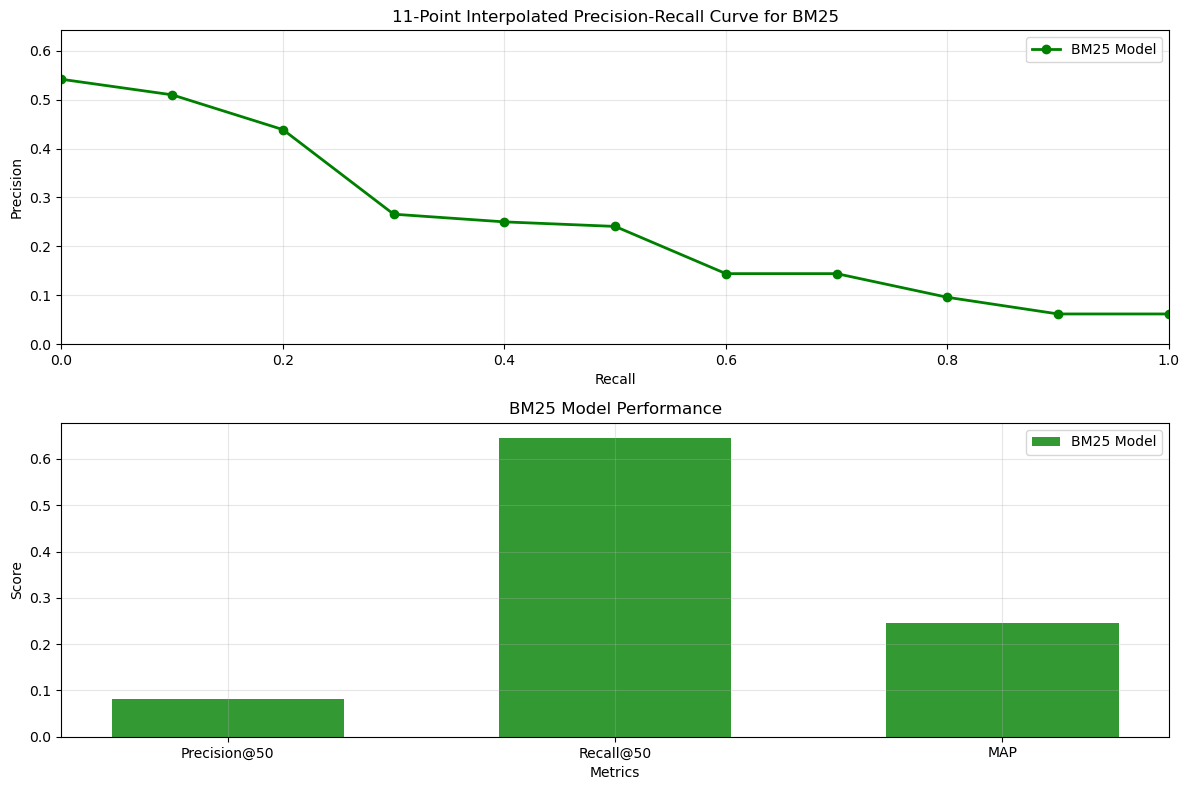


11-Point Interpolated Precision Values:
Recall | BM25 Model
-------|----------
   0.0 |   0.5416
   0.1 |   0.5098
   0.2 |   0.4387
   0.3 |   0.2658
   0.4 |   0.2501
   0.5 |   0.2408
   0.6 |   0.1443
   0.7 |   0.1443
   0.8 |   0.0959
   0.9 |   0.0619
   1.0 |   0.0619

EVALUATION COMPLETED


In [8]:
# Evaluation function
def evaluate_bm25_model(model, queries, qrels, model_name, top_k=50):
    """
    Evaluate BM25 model using precision, recall, and MAP
    """
    precisions_at_k = []
    recalls_at_k = []
    average_precisions = []
    all_interpolated_points = []
    
    print(f"\nEvaluating {model_name}...")
    
    for query_id, query_text in queries.items():
        if query_id not in qrels:
            continue
            
        relevant_docs = qrels[query_id]
        if not relevant_docs:
            continue
            
        # Get search results
        results = model.search(query_text, top_k=top_k)
        retrieved_docs = [r['doc_id'] for r in results]
        
        # Calculate metrics
        precision, recall = calculate_precision_recall(relevant_docs, retrieved_docs, k=top_k)
        ap = calculate_average_precision(relevant_docs, retrieved_docs)
        
        precisions_at_k.append(precision)
        recalls_at_k.append(recall)
        average_precisions.append(ap)
        
        # Calculate precision-recall curve for interpolation
        pr_pairs = []
        for i in range(1, min(len(retrieved_docs), 20) + 1):  # First 20 results
            p, r = calculate_precision_recall(relevant_docs, retrieved_docs, k=i)
            pr_pairs.append((p, r))
        
        interpolated = interpolate_precision_recall(pr_pairs)
        all_interpolated_points.append(interpolated)
    
    # Calculate overall metrics
    avg_precision = np.mean(precisions_at_k)
    avg_recall = np.mean(recalls_at_k)
    map_score = np.mean(average_precisions)
    
    # Calculate 11-point interpolated precision
    if all_interpolated_points:
        recall_levels = np.arange(0.0, 1.1, 0.1)
        mean_interpolated_precisions = []
        
        for i, recall_level in enumerate(recall_levels):
            precisions_at_level = [points[i][1] for points in all_interpolated_points]
            mean_interpolated_precisions.append(np.mean(precisions_at_level))
    else:
        mean_interpolated_precisions = [0.0] * 11
    
    return {
        'precision': avg_precision,
        'recall': avg_recall,
        'map': map_score,
        'interpolated_precisions': mean_interpolated_precisions,
        'num_queries': len(average_precisions)
    }

# Select a subset of queries for evaluation (first 20 queries with relevance judgments)
eval_queries = {}
eval_count = 0
for query_id in sorted(qrels.keys()):
    if eval_count >= 20:
        break
    if query_id in queries and len(qrels[query_id]) > 0:
        eval_queries[query_id] = queries[query_id]
        eval_count += 1

print(f"Evaluating on {len(eval_queries)} queries with relevance judgments")
print("Sample evaluation queries:")
for i, (qid, qtext) in enumerate(list(eval_queries.items())[:3]):
    print(f"  Query {qid}: {qtext[:60]}...")
    print(f"    Relevant docs: {len(qrels[qid])}")

# Evaluate BM25 model
bm25_results = evaluate_bm25_model(bm25_search, eval_queries, qrels, "BM25 Model")

# Display results
print("\n" + "="*60)
print("BM25 EVALUATION RESULTS")
print("="*60)

print(f"\nBM25 Model Results:")
print(f"  Average Precision@50: {bm25_results['precision']:.4f}")
print(f"  Average Recall@50:    {bm25_results['recall']:.4f}")
print(f"  MAP:                  {bm25_results['map']:.4f}")
print(f"  Number of queries:    {bm25_results['num_queries']}")




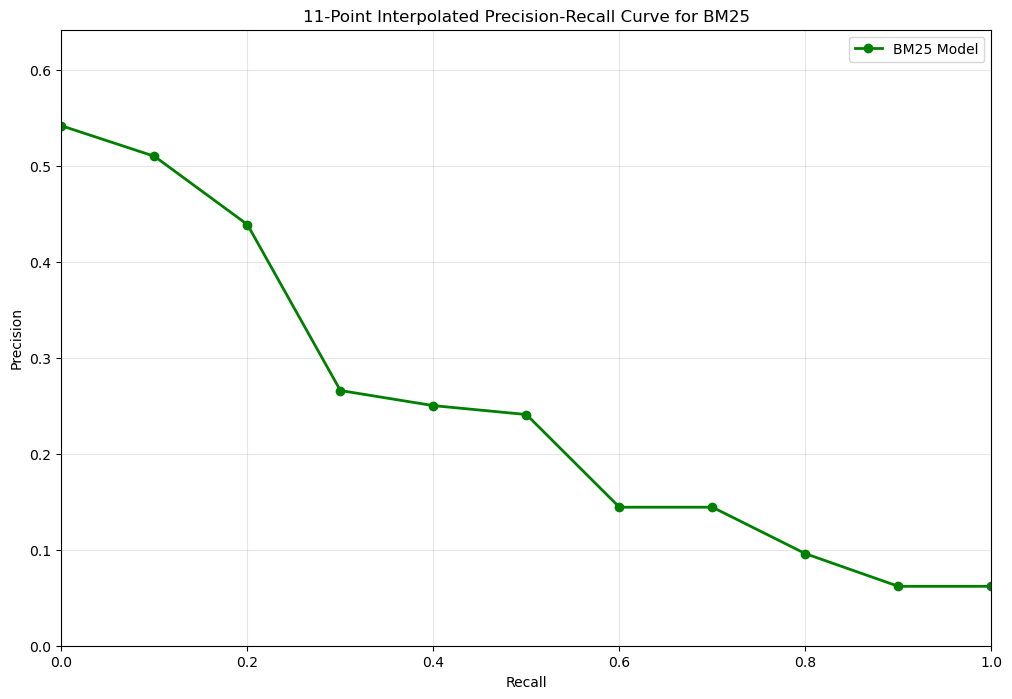

In [26]:
# Plot 11-point interpolated precision-recall curves
plt.figure(figsize=(12, 8))
recall_levels = np.arange(0.0, 1.1, 0.1)


plt.plot(recall_levels, bm25_results['interpolated_precisions'], 'go-', label='BM25 Model', linewidth=2, markersize=6)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('11-Point Interpolated Precision-Recall Curve for BM25')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)

# Determine y-axis limit
max_precision = max(bm25_results['interpolated_precisions'])
if max_precision > 0:
    plt.ylim(0, max_precision + 0.1)
else:
    plt.ylim(0, 1)



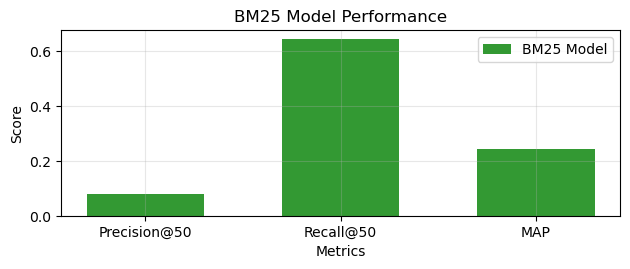


11-Point Interpolated Precision Values:
Recall | BM25 Model
-------|----------
   0.0 |   0.5416
   0.1 |   0.5098
   0.2 |   0.4387
   0.3 |   0.2658
   0.4 |   0.2501
   0.5 |   0.2408
   0.6 |   0.1443
   0.7 |   0.1443
   0.8 |   0.0959
   0.9 |   0.0619
   1.0 |   0.0619

EVALUATION COMPLETED


In [24]:
# Plot metrics bar chart
plt.subplot(2, 1, 2)
metrics = ['Precision@50', 'Recall@50', 'MAP']
bm25_values = [bm25_results['precision'], bm25_results['recall'], bm25_results['map']]

x = np.arange(len(metrics))
width = 0.6

plt.bar(x, bm25_values, width, label='BM25 Model', alpha=0.8, color='green')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('BM25 Model Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n11-Point Interpolated Precision Values:")
print("Recall | BM25 Model")
print("-------|----------")
for i, recall in enumerate(recall_levels):
    bm25_prec = bm25_results['interpolated_precisions'][i]
    print(f"{recall:6.1f} | {bm25_prec:8.4f}")

print("\n" + "="*60)
print("EVALUATION COMPLETED")
print("="*60)

In [25]:
# Detailed evaluation example with specific queries
print("=== DETAILED EVALUATION EXAMPLE ===")
print()

# Take first few queries with relevance judgments for detailed analysis
sample_queries = dict(list(eval_queries.items())[:3])

for query_id, query_text in sample_queries.items():
    print(f"Query {query_id}: {query_text}")
    print(f"Relevant documents ({len(qrels[query_id])}): {qrels[query_id][:10]}")
    
    # Get results from BM25 model
    bm25_results_sample = bm25_search.search(query_text, top_k=10)
    
    print("\nTop 5 BM25 Results:")
    for i, result in enumerate(bm25_results_sample[:5]):
        doc_id = result['doc_id']
        similarity = result['similarity']
        is_relevant = "✓" if doc_id in qrels[query_id] else "✗"
        print(f"  {i+1}. Doc {doc_id} (score: {similarity:.4f}) {is_relevant}")
    
    # Calculate precision@5 for this query
    bm25_relevant_at_5 = sum(1 for r in bm25_results_sample[:5] if r['doc_id'] in qrels[query_id])
    
    print(f"\nPrecision@5:")
    print(f"  BM25 Model: {bm25_relevant_at_5}/5 = {bm25_relevant_at_5/5:.3f}")
    print("-" * 80)

print("\n=== BM25 MODEL SUMMARY ===")
print(f"Evaluation completed on {len(eval_queries)} queries")
print(f"BM25 Model Performance:")
print(f"  • Precision@50: {bm25_results['precision']:.4f}")
print(f"  • Recall@50: {bm25_results['recall']:.4f}")
print(f"  • MAP: {bm25_results['map']:.4f}")

print(f"\nBM25 Parameters used:")
print(f"  • k1 (term frequency saturation): {bm25_model.k1}")
print(f"  • b (length normalization): {bm25_model.b}")

print(f"\nDataset Statistics:")
print(f"  • Total documents: {len(documents)}")
print(f"  • Total queries: {len(queries)}")
print(f"  • Queries with relevance judgments: {len(qrels)}")
print(f"  • Vocabulary size: {len(bm25_model.idf)}")
print(f"  • Average document length: {bm25_model.avgdl:.2f} terms")

print(f"\n🎯 BM25 model evaluation completed successfully!")


=== DETAILED EVALUATION EXAMPLE ===

Query 1: what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .
Relevant documents (28): ['184', '29', '31', '12', '51', '102', '13', '14', '15', '57']


AttributeError: 'dict' object has no attribute 'get_scores'